In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D, Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import csv
import json 
import pickle
import gc
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [0]:
file = pd.read_csv("/process_file_progress_0.5.csv", header=None)
file.columns = ['comp','daynum','sent_score','sent_magn','open','close']
file.head()

,comp,daynum,sent_score,sent_magn,open,close
0,TIF,37,0.0000,0.000000,78.269997,78.279999
1,CMG,38,0.4939,0.401648,400.500000,402.940002
2,DIS,38,0.2960,0.219123,109.559998,109.000000
3,EBAY,38,-0.4215,0.328668,32.450001,33.250000
4,FB,38,-0.2732,0.200821,132.600006,134.199997


In [0]:
company_group = file.groupby(['comp'], as_index=False).apply(pd.DataFrame.sort_values, ['daynum']).reset_index()
company_group = company_group.drop(columns = ['level_0','level_1'])
company_group.head()

,comp,daynum,sent_score,sent_magn,open,close
0,A,74,0.0000,0.000000,53.430000,53.049999
1,A,80,0.3182,0.237337,52.790001,53.130001
2,A,142,0.0000,0.000000,59.799999,58.660000
3,A,198,0.7003,0.693686,61.430000,61.209999
4,A,200,0.2732,0.200821,61.450001,60.980000


In [0]:
comp_data_array = np.array(company_group)
oh_encoder = OneHotEncoder()
comp_encode = oh_encoder.fit_transform(comp_data_array[:,0:1]).toarray()
comp_encode = np.append(comp_encode, comp_data_array[:,1:],1)
comp_encode = preprocessing.normalize(comp_encode)
np.random.shuffle(comp_encode)

comp_encode_train = comp_encode[:19000,:]
comp_encode_test = comp_encode[19000:, :]

In [0]:
ds = tf.data.Dataset.from_tensor_slices(comp_encode_train)
ds = ds.window(3, shift=1, drop_remainder=True)
ds = ds.flat_map(lambda window: window.batch(3))
ds_train = ds.shuffle(5).map(lambda window: (window[:,:-1], window[:,-1]))
#ds_train= ds.batch(2).prefetch(1)

In [0]:
ds_test = tf.data.Dataset.from_tensor_slices(comp_encode_test)
ds_test = ds_test.window(3, shift=1, drop_remainder=True)
ds_test = ds_test.flat_map(lambda window: window.batch(3))
ds_test = ds_test.shuffle(5).map(lambda window: (window[:,:-1], window[:,-1]))
#ds_test= ds_test.batch(2).prefetch(1)

In [0]:
for i,j in ds_train:
    print(i.numpy())
    print(j.numpy())
    print(i.shape)
    print(j.shape)
    break

[[ 0.          0.          0.         ...  0.          0.
   0.09655788]
 [ 0.          0.          0.         ...  0.00107859  0.00085241
   0.09877783]
 [ 0.          0.          0.         ... -0.00119557  0.00116921
   0.10134961]]
[0.09699443 0.09875367 0.09851126]
(3, 449)
(3,)


In [0]:
#callback for adjusting the learning rate

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e_8*10**(epoch/10))

In [0]:
model = Sequential()
model.add(tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis=-1), input_shape=[449]))
model.add(Conv1D(32, 5, activation="relu"))
model.add(MaxPooling1D(2))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Conv1D(64, 5, activation="relu"))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))

model.compile(optimizer='sgd', metrics=['mse','mae'], loss='mse')
#model.summary(0)

In [0]:
history = model.fit(ds_train, epochs=50, verbose=2, validation_data = ds_test)

Epoch 1/50
18998/18998 - 56s - loss: 0.0069 - mse: 0.0069 - mae: 0.0600 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0384
Epoch 2/50
18998/18998 - 56s - loss: 0.0020 - mse: 0.0020 - mae: 0.0348 - val_loss: 0.0049 - val_mse: 0.0049 - val_mae: 0.0655
Epoch 3/50
18998/18998 - 57s - loss: 0.0014 - mse: 0.0014 - mae: 0.0295 - val_loss: 0.0042 - val_mse: 0.0042 - val_mae: 0.0595
Epoch 4/50
18998/18998 - 55s - loss: 0.0011 - mse: 0.0011 - mae: 0.0261 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0633
Epoch 5/50
18998/18998 - 56s - loss: 9.5128e-04 - mse: 9.5128e-04 - mae: 0.0239 - val_loss: 0.0083 - val_mse: 0.0083 - val_mae: 0.0848
Epoch 6/50
18998/18998 - 56s - loss: 8.4932e-04 - mse: 8.4932e-04 - mae: 0.0224 - val_loss: 0.0083 - val_mse: 0.0083 - val_mae: 0.0852
Epoch 7/50
18998/18998 - 55s - loss: 7.6620e-04 - mse: 7.6620e-04 - mae: 0.0212 - val_loss: 0.0061 - val_mse: 0.0061 - val_mae: 0.0700
Epoch 8/50
18998/18998 - 54s - loss: 7.1590e-04 - mse: 7.1589e-04 - mae: 0.0205 - val_l

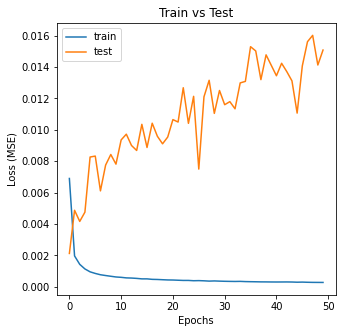

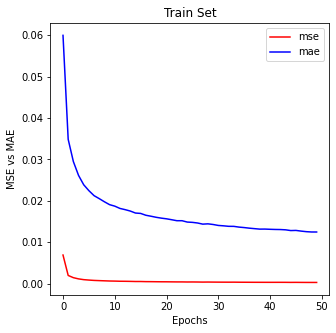

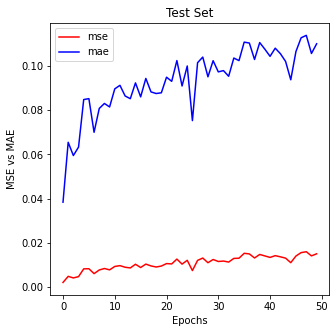

In [0]:

mse = history.history['mse']
mae = history.history['mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_mse = history.history['val_mse']
val_mae = history.history['val_mae']

epochs = 50
x=[]
for i in range(epochs):
    x.append(i)

plt.figure(figsize = (5,5))
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Train vs Test")
plt.plot(x, loss)
plt.plot(x, val_loss)
plt.legend(labels = ['train', 'test'])
plt.show()


plt.figure(figsize = (5,5))
plt.xlabel("Epochs")
plt.ylabel("MSE vs MAE")
plt.title("Train Set")
plt.plot(x, mse, color='red')
plt.plot(x, mae, color='blue')
plt.legend(labels=['mse','mae'])
plt.show()

plt.figure(figsize = (5,5))
plt.xlabel("Epochs")
plt.ylabel("MSE vs MAE")
plt.title("Test Set")
plt.plot(x, val_mse, color='red')
plt.plot(x, val_mae, color='blue')
plt.legend(labels=['mse','mae'])
plt.show()

In [0]:
avg_rmse = np.sqrt(np.average(val_mse))
print("RMSE on test data: ",avg_rmse)

RMSE on test data:  0.10426741531783096


In [0]:
#probably can be improved by adjusting the learning rate dynamically

Create functions to process the data of different alphas auto. Create fn for plots and scheduler

In [0]:
def preprocess_data(alpha):
    file = pd.read_csv("/process_file_progress_"+alpha+".csv", header=None)
    file.columns = ['comp','daynum','sent_score','sent_magn','open','close']
    company_group = file.groupby(['comp'], as_index=False).apply(pd.DataFrame.sort_values, ['daynum']).reset_index()
    company_group = company_group.drop(columns = ['level_0','level_1'])
    comp_data_array = np.array(company_group)
    oh_encoder = OneHotEncoder()
    comp_encode = oh_encoder.fit_transform(comp_data_array[:,0:1]).toarray()
    comp_encode = np.append(comp_encode, comp_data_array[:,1:],1)
    comp_encode = preprocessing.normalize(comp_encode)
    np.random.shuffle(comp_encode)

    comp_encode_train = comp_encode[:19000,:]
    comp_encode_test = comp_encode[19000:, :]

    return comp_encode_train, comp_encode_test

def convert_to_tfds(data):
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(3, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(3))
    ds = ds.shuffle(5).map(lambda window: (window[:,:-1], window[:,-1]))

    return ds


def create_dnn(learning_rate):
    model = Sequential()
    model.add(tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis=-1), input_shape=[449]))
    model.add(Conv1D(32, 5, activation="relu"))
    model.add(MaxPooling1D(2))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(Conv1D(64, 5, activation="relu"))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1))

    model.compile(optimizer=tf.keras.optimizers.SGD(lr=learning_rate, momentum=0.9), metrics=['mse','mae'], loss='mse')

    return model


def create_plots(history, epochs):
    mse = history.history['mse']
    mae = history.history['mae']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    val_mse = history.history['val_mse']
    val_mae = history.history['val_mae']

    x=[]
    for i in range(epochs):
        x.append(i)

    plt.figure(figsize = (5,5))
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.title("Train vs Test")
    plt.plot(x, loss)
    plt.plot(x, val_loss)
    plt.legend(labels = ['train', 'test'])
    plt.show()


    plt.figure(figsize = (5,5))
    plt.xlabel("Epochs")
    plt.ylabel("MSE vs MAE")
    plt.title("Train Set")
    plt.plot(x, mse, color='red')
    plt.plot(x, mae, color='blue')
    plt.legend(labels=['mse','mae'])
    plt.show()

    plt.figure(figsize = (5,5))
    plt.xlabel("Epochs")
    plt.ylabel("MSE vs MAE")
    plt.title("Test Set")
    plt.plot(x, val_mse, color='red')
    plt.plot(x, val_mae, color='blue')
    plt.legend(labels=['mse','mae'])
    plt.show()

Epoch 1/50
18998/18998 [==============================] - 67s 4ms/step - loss: 0.1045 - mse: 0.1045 - mae: 0.2575 - lr: 1.0000e-07
Epoch 2/50
18998/18998 [==============================] - 65s 3ms/step - loss: 0.0919 - mse: 0.0919 - mae: 0.2332 - lr: 1.5849e-07
Epoch 3/50
18998/18998 [==============================] - 65s 3ms/step - loss: 0.0764 - mse: 0.0764 - mae: 0.2042 - lr: 2.5119e-07
Epoch 4/50
18998/18998 [==============================] - 65s 3ms/step - loss: 0.0605 - mse: 0.0605 - mae: 0.1783 - lr: 3.9811e-07
Epoch 5/50
18998/18998 [==============================] - 64s 3ms/step - loss: 0.0479 - mse: 0.0479 - mae: 0.1630 - lr: 6.3096e-07
Epoch 6/50
18998/18998 [==============================] - 64s 3ms/step - loss: 0.0410 - mse: 0.0410 - mae: 0.1600 - lr: 1.0000e-06
Epoch 7/50
18998/18998 [==============================] - 63s 3ms/step - loss: 0.0388 - mse: 0.0388 - mae: 0.1620 - lr: 1.5849e-06
Epoch 8/50
18998/18998 [==============================] - 64s 3ms/step - loss: 0.03

TypeError: ignored

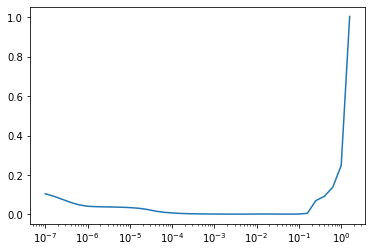

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch:(1e-7)*(10**(epoch/5)))
epochs = 50

train_data, test_data = preprocess_data('0.5')
tf_train = convert_to_tfds(train_data)
tf_test = convert_to_tfds(test_data)
model = create_dnn(1e-7)
lr_check = model.fit(tf_train, epochs=epochs, callbacks = [lr_schedule])
lrs = (1e-7)*(10**(np.arange(epochs)/5))
plt.semilogx(lrs, lr_check.history['loss'])
plt.axis([1e-7, 1e-3])
plt.show()

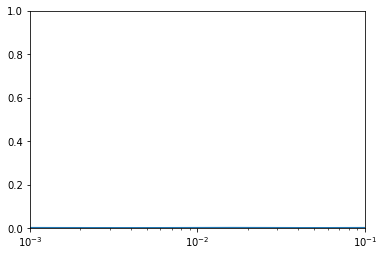

In [0]:
lrs = (1e-7)*(10**(np.arange(epochs)/5))
plt.semilogx(lrs, lr_check.history['loss'])
plt.axis([1e-3, 1e-1,0,1])
plt.show()

Epoch 1/50
18998/18998 [==============================] - 86s 5ms/step - loss: 0.0096 - mse: 0.0096 - mae: 0.0724 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0311
Epoch 2/50
18998/18998 [==============================] - 85s 4ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0384 - val_loss: 0.0023 - val_mse: 0.0023 - val_mae: 0.0425
Epoch 3/50
18998/18998 [==============================] - 85s 4ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0325 - val_loss: 0.0062 - val_mse: 0.0062 - val_mae: 0.0735
Epoch 4/50
18998/18998 [==============================] - 83s 4ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0292 - val_loss: 0.0065 - val_mse: 0.0065 - val_mae: 0.0750
Epoch 5/50
18998/18998 [==============================] - 84s 4ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0271 - val_loss: 0.0066 - val_mse: 0.0066 - val_mae: 0.0751
Epoch 6/50
18998/18998 [==============================] - 84s 4ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0253 - val_loss: 0.0057 - val_mse: 0.0057 - va

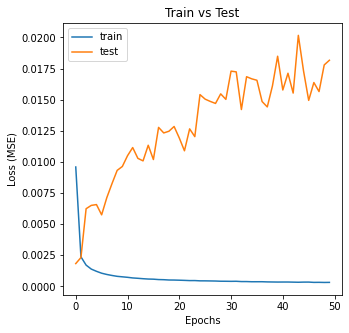

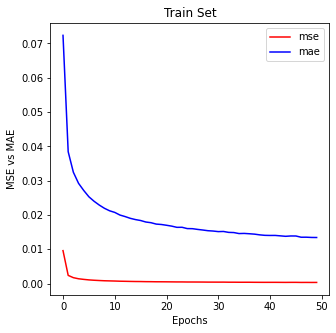

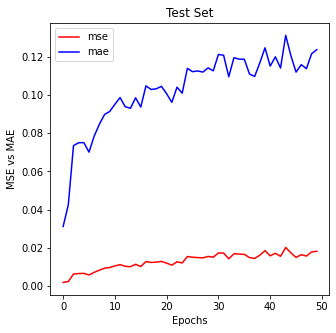

In [0]:
#From this figure we can see that our last epoch had the lowest loss, so we train the model with that learning rate
epochs = 50

train_data, test_data = preprocess_data('0.5')
tf_train = convert_to_tfds(train_data)
tf_test = convert_to_tfds(test_data)

model = create_dnn(6.3096e-04)
history = model.fit(tf_train, epochs=epochs, validation_data=tf_test)
print("For alpha: 0.5, CNN stats")
create_plots(history, epochs)

In [0]:
avg_rmse = np.sqrt(np.average(history.history['val_mse']))
print("RMSE on test data: ",avg_rmse)

RMSE on test data:  0.11375272741362234


Epoch 1/50
18998/18998 [==============================] - 70s 4ms/step - loss: 0.0335 - mse: 0.0335 - mae: 0.1529 - val_loss: 0.0258 - val_mse: 0.0258 - val_mae: 0.1393
Epoch 2/50
18998/18998 [==============================] - 73s 4ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.1150 - val_loss: 0.0101 - val_mse: 0.0101 - val_mae: 0.0872
Epoch 3/50
18998/18998 [==============================] - 71s 4ms/step - loss: 0.0107 - mse: 0.0107 - mae: 0.0849 - val_loss: 0.0068 - val_mse: 0.0068 - val_mae: 0.0649
Epoch 4/50
18998/18998 [==============================] - 70s 4ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0701 - val_loss: 0.0051 - val_mse: 0.0051 - val_mae: 0.0532
Epoch 5/50
18998/18998 [==============================] - 70s 4ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0606 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0438
Epoch 6/50
18998/18998 [==============================] - 71s 4ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0531 - val_loss: 0.0028 - val_mse: 0.0028 - va

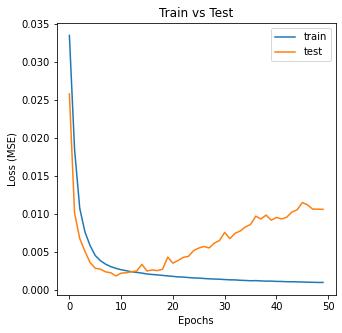

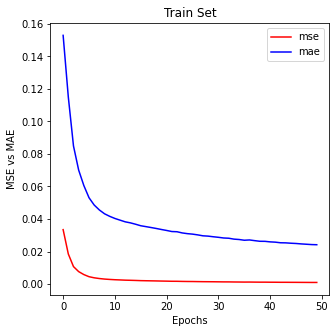

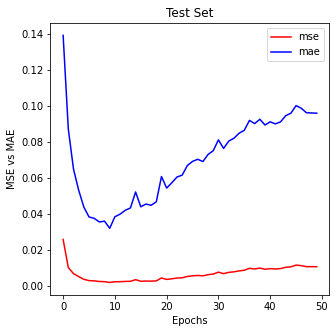

For alpha: 1.5 avg RMSE is 0.08117910545224163
Epoch 1/50
18998/18998 [==============================] - 68s 4ms/step - loss: 0.0357 - mse: 0.0357 - mae: 0.1578 - val_loss: 0.0307 - val_mse: 0.0307 - val_mae: 0.1494
Epoch 2/50
18998/18998 [==============================] - 67s 4ms/step - loss: 0.0231 - mse: 0.0231 - mae: 0.1288 - val_loss: 0.0132 - val_mse: 0.0132 - val_mae: 0.1013
Epoch 3/50
18998/18998 [==============================] - 68s 4ms/step - loss: 0.0120 - mse: 0.0120 - mae: 0.0908 - val_loss: 0.0059 - val_mse: 0.0059 - val_mae: 0.0656
Epoch 4/50
18998/18998 [==============================] - 69s 4ms/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0723 - val_loss: 0.0042 - val_mse: 0.0042 - val_mae: 0.0517
Epoch 5/50
18998/18998 [==============================] - 68s 4ms/step - loss: 0.0060 - mse: 0.0060 - mae: 0.0614 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0422
Epoch 6/50
18998/18998 [==============================] - 67s 4ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0

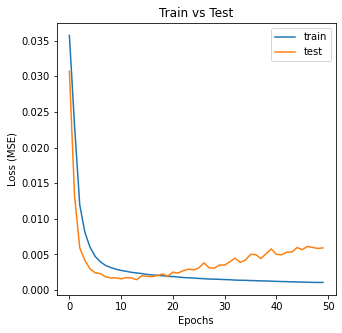

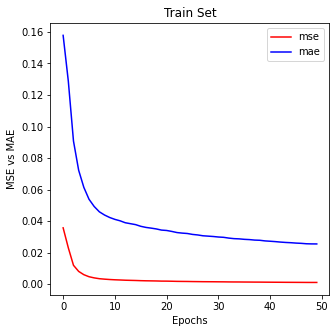

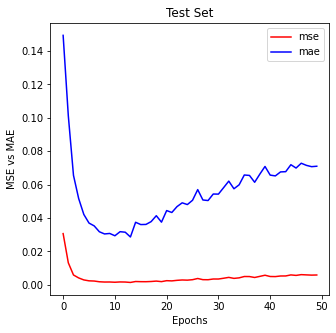

For alpha: 3 avg RMSE is 0.06591442294650708
Epoch 1/50
18998/18998 [==============================] - 68s 4ms/step - loss: 0.0328 - mse: 0.0328 - mae: 0.1514 - val_loss: 0.0249 - val_mse: 0.0249 - val_mae: 0.1368
Epoch 2/50
18998/18998 [==============================] - 67s 4ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.1079 - val_loss: 0.0082 - val_mse: 0.0082 - val_mae: 0.0785
Epoch 3/50
18998/18998 [==============================] - 67s 4ms/step - loss: 0.0096 - mse: 0.0096 - mae: 0.0795 - val_loss: 0.0050 - val_mse: 0.0050 - val_mae: 0.0585
Epoch 4/50
18998/18998 [==============================] - 67s 4ms/step - loss: 0.0069 - mse: 0.0069 - mae: 0.0663 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0495
Epoch 5/50
18998/18998 [==============================] - 70s 4ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0581 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0405
Epoch 6/50
18998/18998 [==============================] - 70s 4ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0

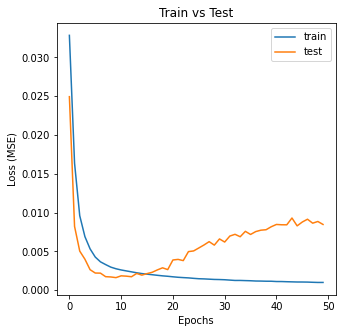

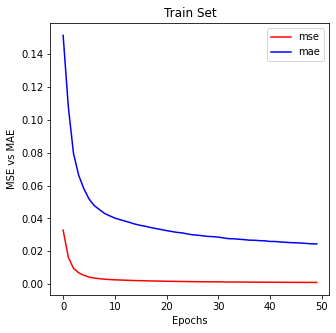

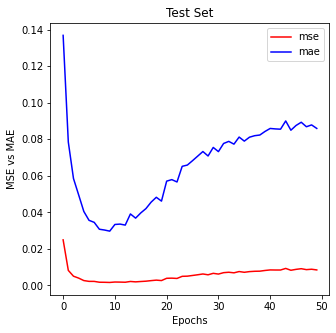

For alpha: 5 avg RMSE is 0.07594424566516449
Epoch 1/50
18998/18998 [==============================] - 67s 4ms/step - loss: 0.0301 - mse: 0.0301 - mae: 0.1450 - val_loss: 0.0194 - val_mse: 0.0194 - val_mae: 0.1236
Epoch 2/50
18998/18998 [==============================] - 67s 4ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0993 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0721
Epoch 3/50
18998/18998 [==============================] - 67s 4ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0754 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0562
Epoch 4/50
18998/18998 [==============================] - 67s 4ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0633 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0434
Epoch 5/50
18998/18998 [==============================] - 67s 4ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0552 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0390
Epoch 6/50
18998/18998 [==============================] - 67s 4ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0

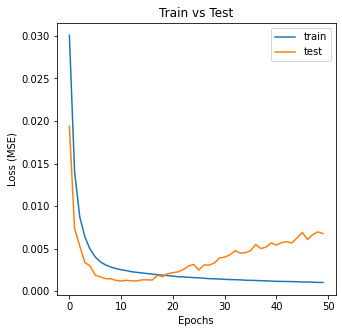

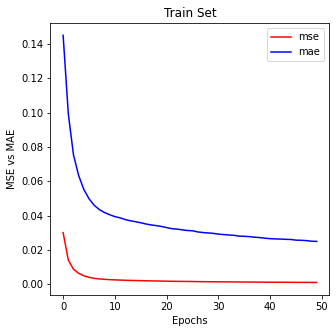

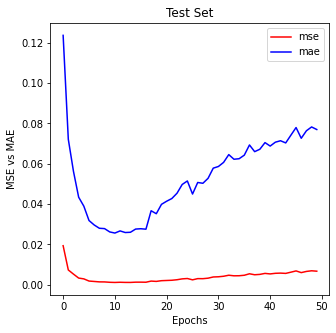

For alpha: 8 avg RMSE is 0.06329529918686264
Epoch 1/50
18998/18998 [==============================] - 72s 4ms/step - loss: 0.0353 - mse: 0.0353 - mae: 0.1569 - val_loss: 0.0299 - val_mse: 0.0299 - val_mae: 0.1498
Epoch 2/50
18998/18998 [==============================] - 69s 4ms/step - loss: 0.0220 - mse: 0.0220 - mae: 0.1258 - val_loss: 0.0127 - val_mse: 0.0127 - val_mae: 0.0997
Epoch 3/50
18998/18998 [==============================] - 68s 4ms/step - loss: 0.0119 - mse: 0.0119 - mae: 0.0902 - val_loss: 0.0062 - val_mse: 0.0062 - val_mae: 0.0672
Epoch 4/50
18998/18998 [==============================] - 68s 4ms/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0730 - val_loss: 0.0041 - val_mse: 0.0041 - val_mae: 0.0532
Epoch 5/50
18998/18998 [==============================] - 69s 4ms/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0621 - val_loss: 0.0029 - val_mse: 0.0029 - val_mae: 0.0420
Epoch 6/50
18998/18998 [==============================] - 68s 4ms/step - loss: 0.0048 - mse: 0.0048 - mae: 0.0

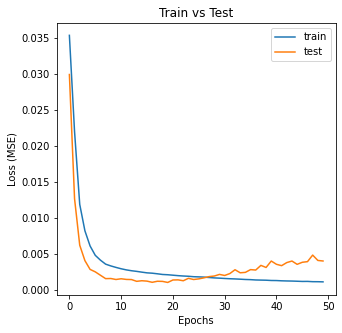

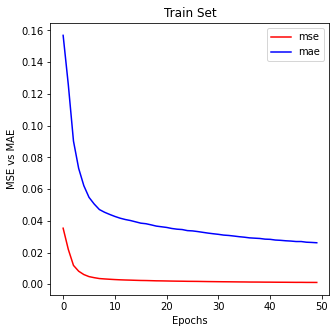

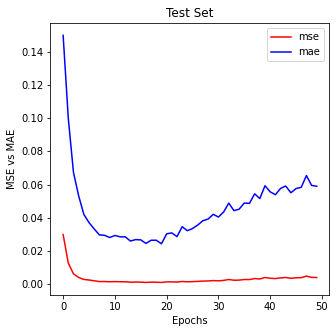

For alpha: 10 avg RMSE is 0.05687235520836792
Epoch 1/50
18998/18998 [==============================] - 69s 4ms/step - loss: 0.0291 - mse: 0.0291 - mae: 0.1425 - val_loss: 0.0174 - val_mse: 0.0174 - val_mae: 0.1140
Epoch 2/50
18998/18998 [==============================] - 68s 4ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0962 - val_loss: 0.0065 - val_mse: 0.0065 - val_mae: 0.0690
Epoch 3/50
18998/18998 [==============================] - 68s 4ms/step - loss: 0.0085 - mse: 0.0085 - mae: 0.0742 - val_loss: 0.0042 - val_mse: 0.0042 - val_mae: 0.0532
Epoch 4/50
18998/18998 [==============================] - 68s 4ms/step - loss: 0.0062 - mse: 0.0062 - mae: 0.0624 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0433
Epoch 5/50
18998/18998 [==============================] - 68s 4ms/step - loss: 0.0048 - mse: 0.0048 - mae: 0.0544 - val_loss: 0.0024 - val_mse: 0.0024 - val_mae: 0.0361
Epoch 6/50
18998/18998 [==============================] - 68s 4ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.

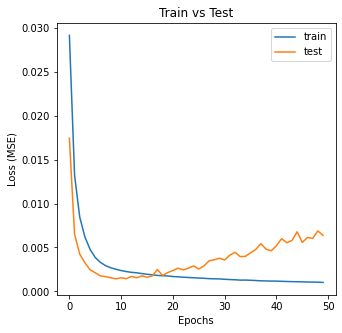

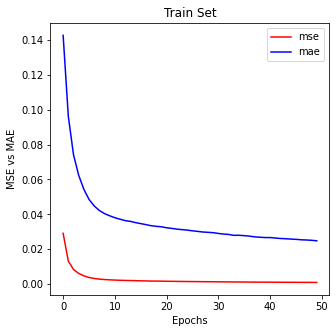

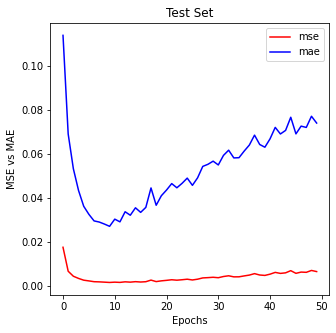

For alpha: 15 avg RMSE is 0.062264713686175636


In [6]:
alphas = ['1.5','3','5','8','10','15']

for i in alphas:
    epochs = 50
    train_data, test_data = preprocess_data(i)
    tf_train = convert_to_tfds(train_data)
    tf_test = convert_to_tfds(test_data)
    #learning rate taken from previous model stats

    model = create_dnn(6.3096e-05)
    history = model.fit(tf_train, epochs=epochs, validation_data=tf_test)
    print("For alpha: 0.5, CNN stats")
    create_plots(history, epochs)

    print("For alpha: {} avg RMSE is {}".format(i, np.sqrt(np.average(history.history['val_mse']))))